In [ ]:
import numpy as np 
import deerlab as dl 
import matplotlib.pyplot as plt
from copy import deepcopy

path = '../data/'
file = 'example_5pridme_overtones.DTA'

tau1 = 0.4
tau2 = 3.2
tmin = 0.28

# Load the experimental data
t,Vexp = dl.deerload(path + file)

# Pre-processing
Vexp /= np.max(Vexp)     # Rescaling (aesthetic)
t = t + tmin             # Account for time axis shift

r = np.linspace(1, 4, 100) # nm
pulselength = 0.024 # us, pi-pulse length


In [12]:
# Construct the experiment with overtones
Novertones = 3 # we expect 3 dipolar overtones (user input)
Ps = np.array([0.4, 0.5, 0.1]) # normalized overtone coefficients (user input)
Ps /= sum(Ps)

# Building an extended RIDME model allowing higher harmonics.
def reftimes(tau1,tau2):
    return [tau1]*Novertones
# Pulse delays 
delays = [tau1,tau2]
# Theoretical dipolar harmonics
harmonics = list(range(1,Novertones+1))
# Harmonics labels
pathwaylabels = np.arange(1,len(harmonics)+1)

my_ridme = dl.ExperimentInfo('5-pulse RIDME with overtones', 
                             reftimes, 
                             harmonics, 
                             pulselength, 
                             pathwaylabels, 
                             delays
                             )

Vmodel = dl.dipolarmodel(t, r, Bmodel=dl.bg_strexp, experiment=my_ridme)

print(Vmodel)

# Linking refocusing times of different overtones
Vmodel = dl.link(Vmodel, reftime=[f'reftime{n+1}' for n in range(Novertones)])
# Introducing a total modulation depth lam = lam1 + lam2 + lam3
Vmodel.addnonlinear(key='lam', 
                    lb=0, 
                    ub=1, 
                    par0=0.1, 
                    name='Modulation depth', 
                    unit='', 
                    description='Overall modulation depth'
                    )

# Fixing intensity ratios of overtones
# This is a very general and unfortunately overcomplicated expression. 
# The purpose is to avoid code adjustments if `Nonvertones` is changed.
# For instance, if Novertones == 3, it is then equivalent to
# Vmodel = dl.relate(   Vmodel,
#                      lam1=lambda lam: lam*Ps[0],
#                      lam2=lambda lam: lam*Ps[1], 
#                      lam3=lambda lam: lam*Ps[2]
#                   )
# In such a form though, you have to modify this input manually.

from functools import partial
relation = lambda lam, n: lam*Ps[n]
restraints = {f'lam{n+1}' : partial(relation, n=n) for n in range(Novertones)}
Vmodel = dl.relate(Vmodel, **restraints)

# Fit the model to the data
results = dl.fit(Vmodel, Vexp)

# Print a results summary
print(results)

Description: 5-pulse RIDME with overtones dipolar signal model
Signature: (lam1, reftime1, lam2, reftime2, lam3, reftime3, decay, stretch, P)
Constants: []
Parameter Table: 
========== ======= ======= ======= ======== ======== ====== ====================================== 
 Name       Lower   Start   Upper    Type    Frozen   Unit   Description                           
========== ======= ======= ======= ======== ======== ====== ====================================== 
 lam1           0    0.01       1   nonlin     No            Amplitude of pathway #1               
 reftime1   0.328     0.4   0.472   nonlin     No      μs    Refocusing time of pathway #1         
 lam2           0    0.01       1   nonlin     No            Amplitude of pathway #2               
 reftime2   0.328     0.4   0.472   nonlin     No      μs    Refocusing time of pathway #2         
 lam3           0    0.01       1   nonlin     No            Amplitude of pathway #3               
 reftime3   0.328     0.4 

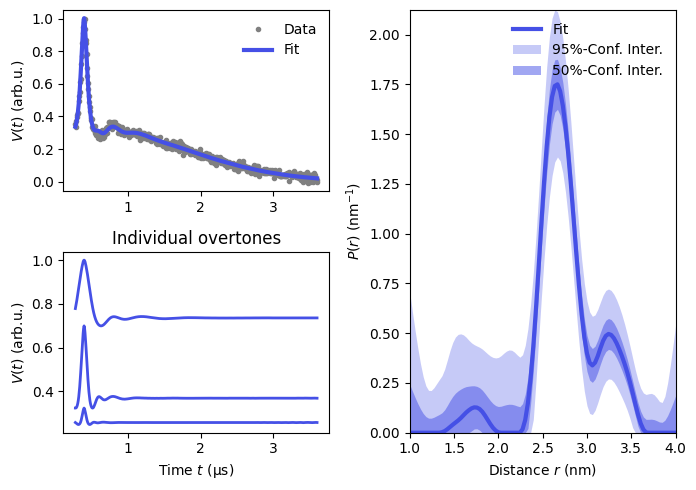

In [15]:
# Extract fitted dipolar signal
Vfit = results.model

# Extract fitted distance distribution
Pfit = results.P
Pci95 = results.PUncert.ci(95)
Pci50 = results.PUncert.ci(50)

# Extract the unmodulated contribution
Bfcn = lambda lam,decay,stretch,reftime: results.P_scale*(1-lam)*dl.bg_strexp(t-reftime,decay,stretch)
Bfit = results.evaluate(Bfcn)
Bci = results.propagate(Bfcn).ci(95)

# Extracting individual dipolar overtones [optional]
lam = results.lam
kernels = [dl.dipolarkernel(t, r, pathways=[{'amp': 1-lam*Ps[j]}, 
                                            {'amp': lam*Ps[j], 'reftime': tau1, 'harmonic': j+1}]) for j in range(Novertones)]
Vharms = [K @ Pfit for K in kernels]

plt.figure(figsize=[7,5])
violet = '#4550e6'
ax1 = plt.subplot(221)
# Plot experimental and fitted data
plt.plot(t,Vexp,'.',color='grey',label='Data')
plt.plot(t,Vfit,linewidth=3,color=violet,label='Fit')
#plt.plot(t,Bfit,'--',linewidth=3,color=violet,label='Unmodulated contribution')
#plt.fill_between(t,Bci[:,0],Bci[:,1],color=violet,alpha=0.3)
plt.legend(frameon=False,loc='best')
plt.ylabel('$V(t)$ (arb.u.)')

# Plot indiviual overtones [optional]
plt.subplot(223, sharex=ax1)
shift = 0
for Vovertone in Vharms:
    plt.plot(t,Vovertone-shift,linewidth=2,color=violet)
    shift += np.max(Vovertone) - np.min(Vovertone)
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')
plt.title('Individual overtones')

# Plot the distance distribution
plt.subplot(2, 2, (2, 4))
plt.plot(r,Pfit,color=violet,linewidth=3,label='Fit')
plt.fill_between(r,Pci95[:,0],Pci95[:,1],alpha=0.3,color=violet,label='95%-Conf. Inter.',linewidth=0)
plt.fill_between(r,Pci50[:,0],Pci50[:,1],alpha=0.5,color=violet,label='50%-Conf. Inter.',linewidth=0)
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')
plt.tight_layout()
plt.show()